In [5]:
import pandas as pd
import numpy as np

from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import time


2024-10-17 10:48:56.596358: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 10:48:56.663887: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 10:48:56.796642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 10:48:56.957153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 10:48:57.003603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 10:48:57.231069: I tensorflow/core/platform/cpu_feature_gu

In [1]:


batch_sizes = [256, 32, 8, 1]
results = []

for batch_size in batch_sizes:

    df_train = pd.read_csv("../input/mitbih_train.csv", header=None)
    df_train = df_train.sample(frac=1)
    df_test = pd.read_csv("../input/mitbih_test.csv", header=None)

    Y = np.array(df_train[187].values).astype(np.int8)
    X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

    Y_test = np.array(df_test[187].values).astype(np.int8)
    X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    #print("X train:", np.shape(X), "Y train", np.shape(Y))
    #print("X test:", np.shape(X_test), "Y test", np.shape(Y_test))
    t1 = time.time()

    def get_model():
        nclass = 5
        inp = Input(shape=(187, 1))
        img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
        img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
        img_1 = MaxPool1D(pool_size=2)(img_1)
        img_1 = Dropout(rate=0.1)(img_1)
        img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
        img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
        img_1 = MaxPool1D(pool_size=2)(img_1)
        img_1 = Dropout(rate=0.1)(img_1)
        img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
        img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
        img_1 = MaxPool1D(pool_size=2)(img_1)
        img_1 = Dropout(rate=0.1)(img_1)
        img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
        img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
        img_1 = GlobalMaxPool1D()(img_1)
        img_1 = Dropout(rate=0.2)(img_1)

        dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
        dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
        dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

        model = models.Model(inputs=inp, outputs=dense_1)
        opt = optimizers.Adam(0.001)

        model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
        #model.summary()
        return model

    model = get_model()
    file_path = "baseline_cnn_mitbih.keras"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    model.fit(X, Y, batch_size=batch_size, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    model.load_weights(file_path)

    pred_test = model.predict(X_test)
    pred_test = np.argmax(pred_test, axis=-1)

    print("\n\n\nBatch size: ", batch_size)

    f1 = f1_score(Y_test, pred_test, average="macro")

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test)

    print("Test accuracy score : %s "% acc)

    t2 = time.time()
    print("Total time elapsed:", t2 - t1)
    
    results.append([batch_size, f1, acc, t2 - t1])

2024-10-16 15:14:28.886460: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 15:14:28.962504: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 15:14:29.042385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 15:14:29.111673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 15:14:29.132945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 15:14:29.269735: I tensorflow/core/platform/cpu_feature_gu

Epoch 1/1000

Epoch 1: val_acc improved from -inf to 0.88225, saving model to baseline_cnn_mitbih.keras
308/308 - 28s - 92ms/step - acc: 0.8505 - loss: 0.5129 - val_acc: 0.8823 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 2/1000

Epoch 2: val_acc improved from 0.88225 to 0.93227, saving model to baseline_cnn_mitbih.keras
308/308 - 24s - 79ms/step - acc: 0.9043 - loss: 0.3320 - val_acc: 0.9323 - val_loss: 0.2329 - learning_rate: 0.0010
Epoch 3/1000

Epoch 3: val_acc improved from 0.93227 to 0.94050, saving model to baseline_cnn_mitbih.keras
308/308 - 24s - 79ms/step - acc: 0.9332 - loss: 0.2436 - val_acc: 0.9405 - val_loss: 0.1999 - learning_rate: 0.0010
Epoch 4/1000

Epoch 4: val_acc improved from 0.94050 to 0.95306, saving model to baseline_cnn_mitbih.keras
308/308 - 24s - 78ms/step - acc: 0.9415 - loss: 0.2092 - val_acc: 0.9531 - val_loss: 0.1717 - learning_rate: 0.0010
Epoch 5/1000

Epoch 5: val_acc improved from 0.95306 to 0.95763, saving model to baseline_cnn_mitbih.keras
308/

In [2]:
results_ = np.array(results)
print(results_)

[[2.56000000e+02 9.17645635e-01 9.85337109e-01 1.00497526e+03]
 [3.20000000e+01 9.14916971e-01 9.85291431e-01 1.47623920e+03]
 [8.00000000e+00 9.00878108e-01 9.80038370e-01 5.72808533e+03]
 [1.00000000e+00 3.42024890e-01 8.64882149e-01 1.31983200e+04]]


In [6]:
results_ = np.array([[2.56000000e+02, 9.17645635e-01, 9.85337109e-01, 1.00497526e+03],
 [3.20000000e+01, 9.14916971e-01, 9.85291431e-01, 1.47623920e+03],
 [8.00000000e+00, 9.00878108e-01, 9.80038370e-01, 5.72808533e+03],
 [1.00000000e+00, 3.42024890e-01, 8.64882149e-01, 1.31983200e+04]])

In [8]:
print(results_)

[[2.56000000e+02 9.17645635e-01 9.85337109e-01 1.00497526e+03]
 [3.20000000e+01 9.14916971e-01 9.85291431e-01 1.47623920e+03]
 [8.00000000e+00 9.00878108e-01 9.80038370e-01 5.72808533e+03]
 [1.00000000e+00 3.42024890e-01 8.64882149e-01 1.31983200e+04]]


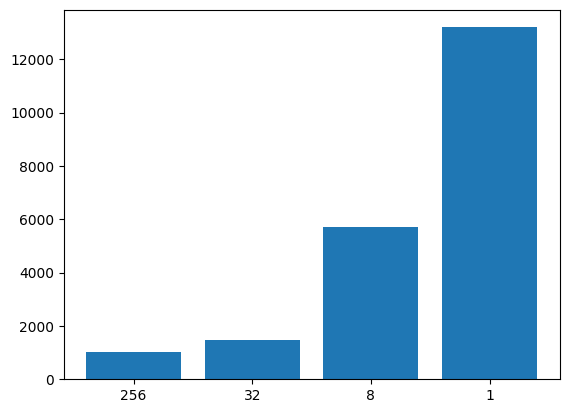

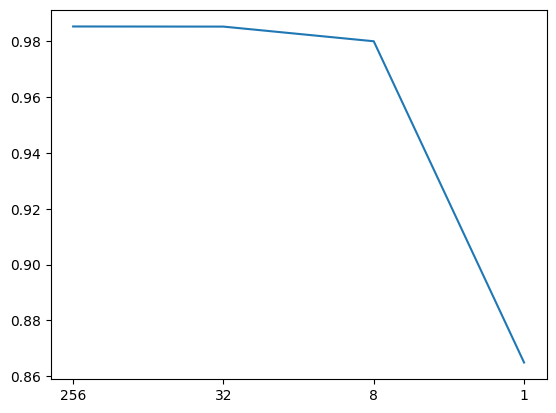

In [14]:
plt.bar(['256', '32', '8', '1'], results_.T[3])
plt.show()
plt.plot(['256', '32', '8', '1'], results_.T[2])
plt.show()